# FPA and Pol II metagene profiles


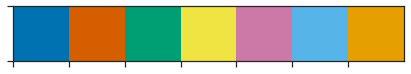

In [1]:
import sys
import re
import os
from glob import glob
import random

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import pyBigWig as pybw

## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 2
style['ytick.major.size'] = 2
sns.set(font_scale=1.4, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
def flatten_intervals(invs):
    flattened = []
    all_invs = iter(np.sort(invs, axis=0))
    inv_start, inv_end = next(all_invs)
    for start, end in all_invs:
        if start <= inv_end:
            inv_end = max(inv_end, end)
        else:
            flattened.append([inv_start, inv_end])
            inv_start, inv_end = start, end
    if not flattened or flattened[-1] != [inv_start, inv_end]:
        flattened.append([inv_start, inv_end])
    return np.array(flattened)


def get_record_range(invs):
    invs = flatten_intervals(invs)
    return invs[0, 0], invs[-1, 1]


def get_gtf_attribute(gtf_record, attribute):
    try:
        attr = re.search(f'{attribute} "(.+?)";', gtf_record[8]).group(1)
    except AttributeError:
        raise ValueError(
            f'Could not parse attribute {attribute} '
            f'from GTF with feature type {record[2]}'
        )
    return attr


def gtf_iterator(gtf_fn,
                 extend_gene_five_prime=0,
                 extend_gene_three_prime=0):
    gtf_records = {}
    with open(gtf_fn) as gtf:
        for i, record in enumerate(gtf):
            record = record.split('\t')
            chrom, _, feat_type, start, end, _, strand = record[:7]
            start = int(start) - 1
            end = int(end)
            if feat_type == 'CDS' or feat_type == 'exon':
                gene_id = get_gtf_attribute(record, 'gene_id')
                idx = (chrom, gene_id, strand)
                if idx not in gtf_records:
                    gtf_records[idx] = {}
                if feat_type not in gtf_records[idx]:
                    gtf_records[idx][feat_type] = []
                gtf_records[idx][feat_type].append((start, end))


    # once whole file is parsed yield the intervals
    for (chrom, gene_id, strand), feat_invs in gtf_records.items():
        gene_start, gene_end = get_record_range(
            feat_invs['exon'],
        )
        gene_length = gene_end - gene_start
        try:
            cds_start, cds_end = get_record_range(
                feat_invs['CDS'],
            )
        except KeyError:
            # non-coding RNA
            continue

        # add extensions to 3' and 5' ends
        start_ext, end_ext = extend_gene_five_prime, extend_gene_three_prime
        if strand == '-':
            start_ext, end_ext = end_ext, start_ext
        gene_start = max(0, gene_start - start_ext)
        gene_end = gene_end + end_ext

        yield chrom, gene_start, gene_end, gene_length, gene_id, strand

In [3]:
gtf_fn = '../helicos_apa_pipeline/annotations/Araport11_GFF3_genes_transposons.201606.no_chr.gtf'
helicos_fwd = '../helicos_apa_pipeline/pipeline/coverage_tracks/col0.cpm.fwd.bw'
helicos_rev = '../helicos_apa_pipeline/pipeline/coverage_tracks/col0.cpm.rev.bw'

In [4]:
def get_tpe_positions(gtf_fn, helicos_fwd_fn, helicos_rev_fn):
    positions = []
    with pybw.open(helicos_fwd_fn) as fwd_bw, pybw.open(helicos_rev_fn) as rev_bw:
        for chrom, start, end, ln, gene_id, strand in gtf_iterator(gtf_fn, extend_gene_three_prime=200):
            bw = fwd_bw if strand == '+' else rev_bw
            try:
                cov = bw.values(chrom, start, end)
            except RuntimeError:
                start = max(0, start)
                end = min(bw.chroms(chrom), end)
                cov = bw.values(chrom, start, end)
            pos = start + np.nanargmax(cov)
            positions.append((chrom, pos, strand, gene_id, ln))
    return pd.DataFrame(positions, columns=['chrom', 'pos', 'strand', 'gene_id', 'length'])

In [5]:
tpe_pos = get_tpe_positions(gtf_fn, helicos_fwd, helicos_rev)

In [6]:
def metagene_profile(positions, bw_fn, w=2000):
    metaprof = []
    with pybw.open(bw_fn) as bw:
        for chrom, pos, strand, *_ in positions.itertuples(index=False):
            start = pos - w
            end = pos + w
            try:
                cov = bw.values(chrom, start, end, numpy=True)
            except RuntimeError:
                if start < 0:
                    lpad = abs(start)
                    start = 0
                else:
                    lpad = 0
                trimmed_end = min(bw.chroms(chrom), end)
                rpad = end - trimmed_end
                cov = bw.values(chrom, start, trimmed_end, numpy=True)
                cov = np.concatenate([
                    np.repeat(0, lpad),
                    cov,
                    np.repeat(0, rpad),
                ])
            if strand == '-':
                cov = cov[::-1]
            metaprof.append(cov)
    metaprof = np.array(metaprof)
    metaprof[np.isnan(metaprof)] = 0
    return metaprof

In [7]:
fpa_fn = '../chipseq_pipeline/pipeline/fpa/coverage_tracks/FPA.bw'
ser2p_fn = '../chipseq_pipeline/pipeline/polii/coverage_tracks/s2p_wt.bw'
ser5p_fn = '../chipseq_pipeline/pipeline/polii/coverage_tracks/s5p_wt.bw'

fpa_chip = metagene_profile(tpe_pos[tpe_pos.length > 2500], fpa_fn)
ser2p_chip = metagene_profile(tpe_pos[tpe_pos.length > 2500], ser2p_fn)
ser5p_chip = metagene_profile(tpe_pos[tpe_pos.length > 2500], ser5p_fn)

print(f'n={sum(tpe_pos.length > 2500)}')

n=10215


/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


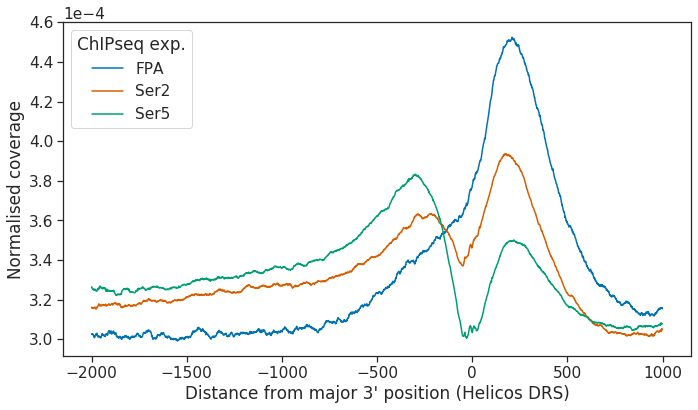

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(-2000, 1000)

ax.plot(x, np.nanmean(fpa_chip[:, :3000] / fpa_chip[:, :3000].sum(1)[:, np.newaxis], axis=0),
        label='FPA')
ax.plot(x, np.nanmean(ser2p_chip[:, :3000] / ser2p_chip[:, :3000].sum(1)[:, np.newaxis], axis=0),
        label='Ser2')
ax.plot(x, np.nanmean(ser5p_chip[:, :3000] / ser5p_chip[:, :3000].sum(1)[:, np.newaxis], axis=0),
        label='Ser5')
ax.legend(loc=2, title='ChIPseq exp.')
ax.set_xlabel('Distance from major 3\' position (Helicos DRS)')
ax.set_ylabel('Normalised coverage')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.tight_layout()
plt.savefig('figures/fpa_chipseq_metagene_long_genes.svg')
plt.show()

In [12]:
fpa_fn = '../chipseq_pipeline/pipeline/fpa/coverage_tracks/FPA.bw'
ser2p_fn = '../chipseq_pipeline/pipeline/polii/coverage_tracks/s2p_wt.bw'
ser5p_fn = '../chipseq_pipeline/pipeline/polii/coverage_tracks/s5p_wt.bw'

fpa_chip = metagene_profile(tpe_pos[tpe_pos.length <= 2500], fpa_fn)
ser2p_chip = metagene_profile(tpe_pos[tpe_pos.length <= 2500], ser2p_fn)
ser5p_chip = metagene_profile(tpe_pos[tpe_pos.length <= 2500], ser5p_fn)

print(f'n={sum(tpe_pos.length <= 2500)}')

n=17440


/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/cluster/ggs_lab/mtparker/.conda/envs/nb_bio/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


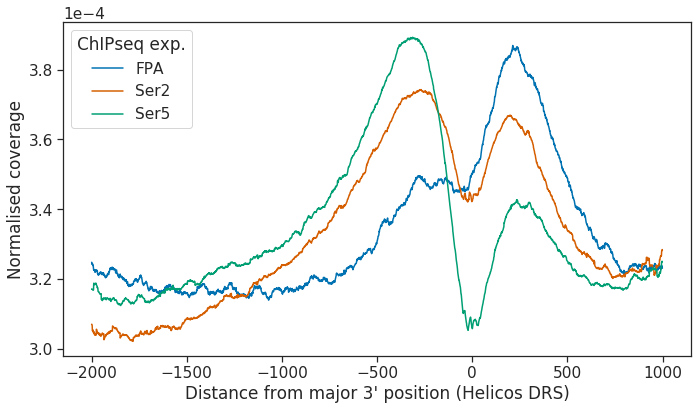

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(-2000, 1000)

ax.plot(x, np.nanmean(fpa_chip[:, :3000] / fpa_chip[:, :3000].sum(1)[:, np.newaxis], axis=0),
        label='FPA')
ax.plot(x, np.nanmean(ser2p_chip[:, :3000] / ser2p_chip[:, :3000].sum(1)[:, np.newaxis], axis=0),
        label='Ser2')
ax.plot(x, np.nanmean(ser5p_chip[:, :3000] / ser5p_chip[:, :3000].sum(1)[:, np.newaxis], axis=0),
        label='Ser5')
ax.legend(loc=2, title='ChIPseq exp.')
ax.set_xlabel('Distance from major 3\' position (Helicos DRS)')
ax.set_ylabel('Normalised coverage')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.tight_layout()
plt.savefig('figures/fpa_chipseq_metagene_short_genes.svg')
plt.show()